#Installations

In [1]:
!pip install --upgrade yfinance

In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import datetime
from scipy.optimize import minimize

In [3]:
!pip install prophet
from prophet import Prophet

d:\studies\s8\algotrade\code\Algotrade\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from sklearn.ensemble import RandomForestRegressor

#Markovich Model with Linear Regression



## Python script stock price prediction using linear regression for later use in markovich model

### markovich() function explained:
    Gets the desired stocks to predict upon, as well as test size and amount
    of portfolios to run. for each stock, call price_forecast() in order to run
    linear regression and get predicted price. Then, calculate annual return
    and covariance matrix for all of the stocks. As learned in class,
    markovich model strength is in its ability to consider the variance of each
    pair or group of stocks in order to get a  better, safer portfolio. For
    each stock give random weight in each simulation, calculate, sharpe ration,
    return and vollatility (risk). Finally, plot the efficiency frontier of all
    the portfolios calculated and mark the safest one, the one eith the highest
    sharp ratio and the one with the highest risk.


### price_forecast() function explained:
    Gets stock name, relevant dates and test size. After downloading stock's
    data from yfinance, 4 different features are selected. data is then split
    into train and test sets, inserted in a linear regression model for training
    and prediction. the prediction received from the model are returned to
    markovich  function for portfolio analysis.



In [5]:
def price_forecast(stock, start_date, end_date, record_percentage_to_predict):
    """

    """
    df = yf.download(stock, start=start_date, end=end_date)

    df['HL_PCT'] = (df['High'] - df['Low']) / df['Low'] * 100.0
    df['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

    df = df[['Close', 'HL_PCT', 'PCT_change', 'Volume']]

    forecast_col = 'Close'
    # forecast_col = 'Adj. Close'
    df.fillna(value=-99999, inplace=True)
    forecast_out = int(math.ceil(record_percentage_to_predict * len(df)))
    df['label'] = df[forecast_col].shift(-forecast_out)
    print(df.head())


    X = np.array(df.drop(['label'], axis=1))
    X = preprocessing.scale(X)
    X_lately = X[-forecast_out:]
    X = X[:-forecast_out]
    df.dropna(inplace=True)
    df['Close'].plot()
    y = np.array(df['label'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=record_percentage_to_predict)
    # clf =  svm.SVR() # #LinearRegression()
    clf = LinearRegression()
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print(confidence)
    forecast_set = clf.predict(X_lately)
    df['Forecast'] = np.nan

    last_date = df.iloc[-1].name
    last_unix = last_date.timestamp()
    one_day = 86400
    next_unix = last_unix + one_day

    for i in forecast_set:
        next_date = datetime.datetime.fromtimestamp(next_unix)
        next_unix += 86400
        df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]

    # df['Close'].plot()
    # df['Forecast'].plot()
    # plt.legend(loc=4)
    # plt.xlabel('Date')
    # plt.ylabel('Price')
    # plt.show()

    col = df['Forecast']
    col = col.dropna()
    return col

## Applying Markovich model

In [6]:
#def markovich(start_date, end_date, Num_porSimulation, selected, record_percentage_to_predict):
def markovich(start_date, end_date, Num_porSimulation, selected, record_percentage_to_predict):

    #yf.pdr_override()
    frame = {}
    for stock in selected:
        # call price_forecast on each stock and get prediction for it's prices
        price = price_forecast(stock, start_date, end_date, record_percentage_to_predict)
        frame[stock] = price
    #frame.to_csv('1.csv')
    table = pd.DataFrame(frame)
    plt.plot(pd.DataFrame(frame))
    pd.DataFrame(frame).to_csv('Out.csv')

    returns_daily = table.pct_change()
    returns_daily.to_csv('Out1.csv')
    returns_annual = ((1 + returns_daily.mean()) ** 254) - 1
    returns_annual.to_csv('Out2.csv')

    # get daily and covariance of returns of the stock
    cov_daily = returns_daily.cov()
    cov_annual = cov_daily * 250

    # empty lists to store returns, volatility and weights of imiginary portfolios
    port_returns = []
    port_volatility = []
    sharpe_ratio = []
    stock_weights = []

    # set the number of combinations for imaginary portfolios
    num_assets = len(selected)
    num_portfolios = Num_porSimulation  # Change porfolio numbers here

    # set random seed for reproduction's sake
    np.random.seed(101)

    # populate the empty lists with each portfolios returns,risk and weights
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, returns_annual)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        sharpe = returns / volatility
        sharpe_ratio.append(sharpe)
        port_returns.append(returns * 100)
        port_volatility.append(volatility * 100)
        stock_weights.append(weights)

    # a dictionary for Returns and Risk values of each portfolio
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility,
                 'Sharpe Ratio': sharpe_ratio}

    # extend original dictionary to accomodate each ticker and weight in the portfolio
    for counter, symbol in enumerate(selected):
        portfolio[symbol + ' Weight'] = [Weight[counter] for Weight in stock_weights]

    # make a nice dataframe of the extended dictionary
    df = pd.DataFrame(portfolio)

    # get better labels for desired arrangement of columns
    column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock + ' Weight' for stock in selected]

    # reorder dataframe columns
    df = df[column_order]

    # plot frontier, max sharpe & min Volatility values with a scatterplot
    # find min Volatility & max sharpe values in the dataframe (df)
    min_volatility = df['Volatility'].min()
    # min_volatility1 = df['Volatility'].min()+1
    max_sharpe = df['Sharpe Ratio'].max()
    max_return = df['Returns'].max()
    max_vol = df['Volatility'].max()
    # use the min, max values to locate and create the two special portfolios
    sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
    min_variance_port = df.loc[df['Volatility'] == min_volatility]
    max_returns = df.loc[df['Returns'] == max_return]
    max_vols = df.loc[df['Volatility'] == max_vol]

    # plot frontier, max sharpe & min Volatility values with a scatterplot
    plt.style.use('seaborn-v0_8-dark')
    df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                    cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
    plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='green', marker='D', s=200)
    plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='orange', marker='D', s=200)
    plt.scatter(x=max_vols['Volatility'], y=max_returns['Returns'], c='red', marker='D', s=200)
    plt.style.use('seaborn-v0_8-dark')

    plt.xlabel('Volatility (Std. Deviation) Percentage %')
    plt.ylabel('Expected Returns Percentage %')
    plt.title('Efficient Frontier')
    plt.subplots_adjust(bottom=0.4)
    # ------------------ Pritning 3 optimal Protfolios -----------------------
    # Setting max_X, max_Y to act as relative border for window size

    red_num = df.index[df["Returns"] == max_return]
    yellow_num = df.index[df['Volatility'] == min_volatility]
    green_num = df.index[df['Sharpe Ratio'] == max_sharpe]
    multseries = pd.Series([1, 1, 1] + [100 for stock in selected],
                           index=['Returns', 'Volatility', 'Sharpe Ratio'] + [stock + ' Weight' for stock in selected])
    with pd.option_context('display.float_format', '%{:,.2f}'.format):
        plt.figtext(0.2, 0.15, "Max returns Porfolio: \n" + df.loc[red_num[0]].multiply(multseries).to_string(),
                    bbox=dict(facecolor='red', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center',
                    wrap=True)
        plt.figtext(0.45, 0.15, "Safest Portfolio: \n" + df.loc[yellow_num[0]].multiply(multseries).to_string(),
                    bbox=dict(facecolor='yellow', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center',
                    wrap=True)
        plt.figtext(0.7, 0.15, "Sharpe  Portfolio: \n" + df.loc[green_num[0]].multiply(multseries).to_string(),
                    bbox=dict(facecolor='green', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center',
                    wrap=True)
    plt.show()

[*********************100%***********************]  1 of 1 completed

test
Price           Close    HL_PCT PCT_change     Volume       label
Ticker            SPY                             SPY            
Date                                                             
2009-01-02  68.760574  3.995553   2.786374  227566300  107.537804
2009-01-05  68.679214  1.926221   0.237505  240349700  108.408226
2009-01-06  69.137825  1.909794  -0.181544  328260900  109.824722
2009-01-07  67.066719  2.283820  -1.445654  280899200  108.519043
2009-01-08  67.340393  1.583582   0.976040  263834400  108.447830
0.958091147647321



<ipython-input-8-c99baf0cb56d>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
[*********************100%***********************]  1 of 1 completed
<ipython-input-8-c99baf0cb56d>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))


Price            Close    HL_PCT PCT_change  Volume        label
Ticker         TA35.TA                      TA35.TA             
Date                                                            
2009-01-01  667.390015  2.128178   1.379292       0  1129.430054
2009-01-04  674.239990  1.713038  -0.580967       0  1135.660034
2009-01-05  679.950012  1.438919   0.793068       0  1146.780029
2009-01-06  702.900024  2.960334   2.909095       0  1141.569946
2009-01-07  694.580017  2.172404  -0.465729       0  1144.849976
0.6074786512944306


[*********************100%***********************]  1 of 1 completed
<ipython-input-8-c99baf0cb56d>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))


Price           Close    HL_PCT PCT_change  Volume      label
Ticker            IEI                          IEI           
Date                                                         
2009-01-02  86.699364  1.115960  -0.940388   78500  99.045502
2009-01-05  86.759789  0.435920  -0.225775  487100  98.948067
2009-01-06  86.842880  0.708356   0.410338  363700  98.858841
2009-01-07  86.978722  0.400941   0.243668   67400  99.053574
2009-01-08  87.144966  0.399999   0.130142   34800  99.118477
-1.981811058880687


[*********************100%***********************]  1 of 1 completed
<ipython-input-8-c99baf0cb56d>:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))


Price           Close    HL_PCT PCT_change   Volume      label
Ticker            LQD                           LQD           
Date                                                          
2009-01-02  54.546364  1.164301  -0.876847  1095800  73.556145
2009-01-05  54.920441  1.638361   1.148279  2938400  73.479713
2009-01-06  55.012592  1.161873   0.217285  2036600  73.511574
2009-01-07  54.551754  1.037407  -0.612401  1675100  73.861801
2009-01-08  54.942089  0.795619   0.735584  1445200  73.861801
0.557083563534285


<ipython-input-9-e26b83b68ef3>:12: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(pd.DataFrame(frame))
<ipython-input-9-e26b83b68ef3>:15: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_daily = table.pct_change()


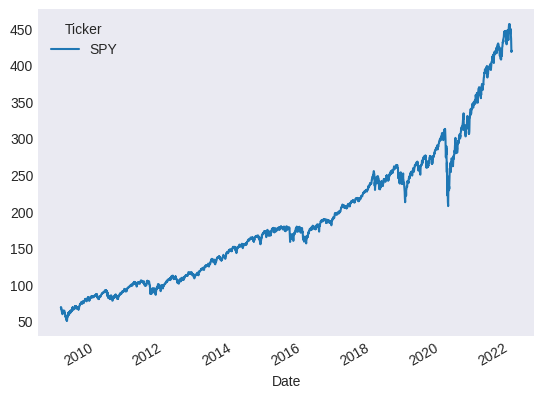

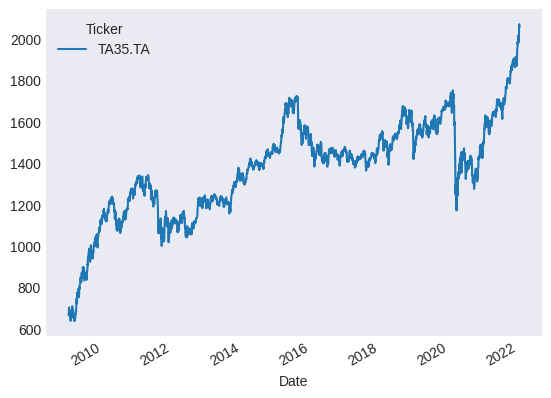

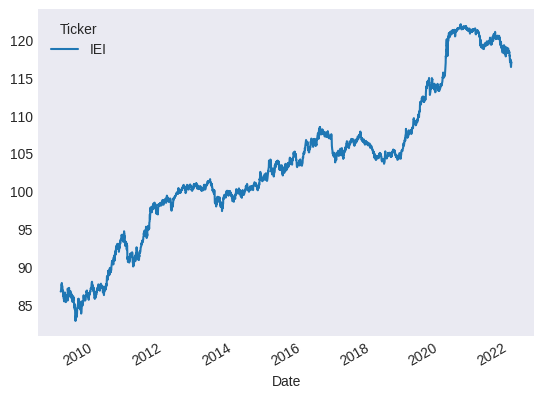

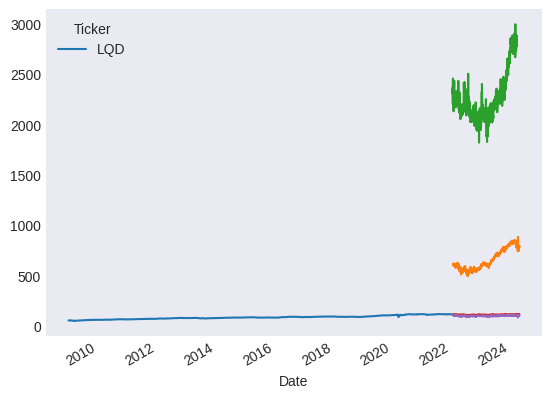

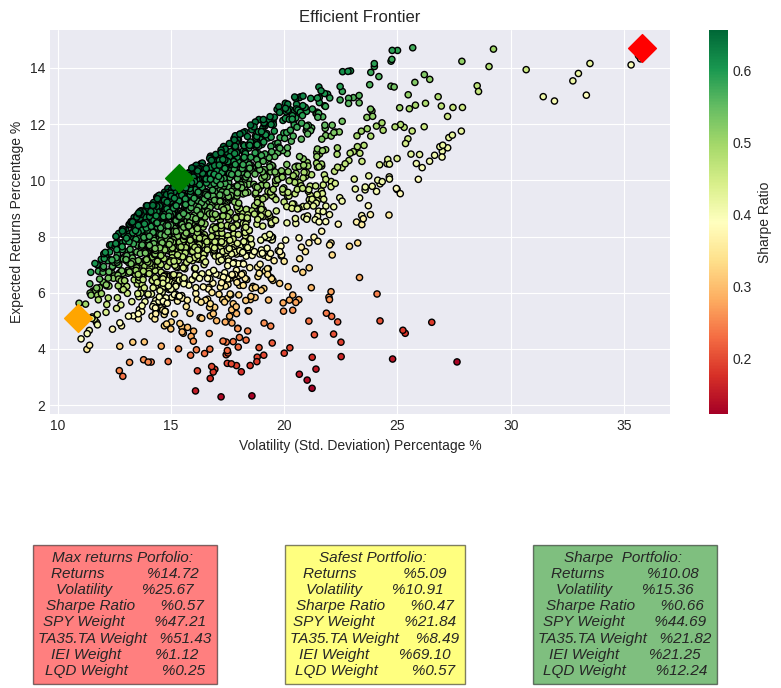

In [11]:
selected = ["SPY", "TA35.TA", "IEI", "LQD"]
record_percentage_to_predict = 0.2
print("test")
markovich("2009-01-01", "2025-05-07", 2000, selected, record_percentage_to_predict)

#Markovich Model with Prophet

##Functions Explanation:
###price_forecast_prophet():
This function uses the Prophet time series model to forecast future stock prices. It receives the stock symbol, date range, and a test size ratio indicating how much of the data should be reserved for prediction.

- **Data Collection:**
Downloads historical stock data from Yahoo Finance for the given time period.

- **Data Preparation:**
Keeps only the Date and Close columns (since Prophet requires a specific format).
Renames columns to ds (date) and y (value), as required by Prophet.
Ensures the y column is numeric and removes any rows with missing values.

- **Forecasting Window:**
 Determines how many future days to predict, based on the record_percentage_to_predict parameter.

- **Model Training:**
Splits the dataset into training and prediction segments.
Trains the Prophet model on the historical data (excluding the future portion).

- **Prediction:**
Uses Prophet to generate a future dataframe and make predictions.
Extracts and returns only the forecasted values for the future period.

- **Return Value:**
Returns a series of predicted future stock prices, which can be passed to the prophet() function for portfolio analysis.

###prohpet():
This function implements the Markowitz portfolio optimization model using forecasted stock prices generated by the Prophet model. It receives a list of selected stocks, date range, number of portfolios to simulate, and a test size percentage.

- **Forecasting Prices with Prophet:**
For each selected stock, the price_forecast_prophet() function is called to generate future price predictions using Facebook Prophet.
The predicted price series for all stocks are stored in a dictionary and combined into a DataFrame.

- **Calculating Returns and Covariance:**
Converts the predicted prices into daily returns using pct_change().
Calculates annual returns by compounding daily averages.
Computes the annual covariance matrix, which reflects how stock returns move together — a key factor in portfolio risk.

- **Simulating Portfolios:**
Randomly generates weights for each stock across many portfolios (as specified by Num_porSimulation).
 **For each simulated portfolio:**
  - Calculates expected return, volatility (risk), and Sharpe ratio (return/risk).
Stores these metrics along with the stock weights.

- **Building the Portfolio Table:**
Combines all calculated metrics and weights into a DataFrame.
Reorders columns for clarity and plotting.

- **Identifying Optimal Portfolios:**

  - Maximum return

  - Minimum volatility (safest)

  - Maximum Sharpe ratio (best risk-adjusted return)

- **Plotting Efficient Frontier:**
Uses a scatter plot to visualize all portfolios, colored by Sharpe ratio.
Highlights the optimal portfolios using distinct markers.
Displays portfolio weights and metrics below the chart in styled boxes.

In [7]:
def price_forecast_prophet(stock, start_date, end_date, record_percentage_to_predict):
    df = yf.download(stock, start=start_date, end=end_date)

    # Only keep 'Date' and 'Close', ensure it's in the right format
    df = df.reset_index()[['Date', 'Close']].dropna()
    df.columns = ['ds', 'y']  # Prophet requires these exact names
    df['y'] = pd.to_numeric(df['y'], errors='coerce')  # Coerce non-numeric values

    # Drop any rows with NaN after coercion
    df = df.dropna()

    # Forecast horizon
    forecast_out = int(math.ceil(record_percentage_to_predict * len(df)))
    train_df = df[:-forecast_out]

    # Fit the Prophet model
    model = Prophet()
    model.fit(train_df)

    # Create future dataframe and predict
    future = model.make_future_dataframe(periods=forecast_out)
    forecast = model.predict(future)

    # Return only forecasted values (the "future")
    forecast_df = forecast[['ds', 'yhat']].set_index('ds')
    predicted_series = forecast_df['yhat'].tail(forecast_out)

    return predicted_series


In [9]:
def prophet(start_date, end_date, Num_porSimulation, selected, record_percentage_to_predict):

    #yf.pdr_override()
    frame = {}
    for stock in selected:
        # call price_forecast on each stock and get prediction for it's prices
        # price = price_forecast(stock, start_date, end_date, record_percentage_to_predict)
        price = price_forecast_prophet(stock, start_date, end_date, record_percentage_to_predict)
        frame[stock] = price
    #frame.to_csv('1.csv')
    table = pd.DataFrame(frame)
    plt.plot(pd.DataFrame(frame))
    pd.DataFrame(frame).to_csv('Out.csv')

    returns_daily = table.pct_change()
    returns_daily.to_csv('Out1.csv')
    returns_annual = ((1 + returns_daily.mean()) ** 254) - 1
    returns_annual.to_csv('Out2.csv')

    # get daily and covariance of returns of the stock
    cov_daily = returns_daily.cov()
    cov_annual = cov_daily * 250

    # empty lists to store returns, volatility and weights of imiginary portfolios
    port_returns = []
    port_volatility = []
    sharpe_ratio = []
    stock_weights = []

    # set the number of combinations for imaginary portfolios
    num_assets = len(selected)
    num_portfolios = Num_porSimulation  # Change porfolio numbers here

    # set random seed for reproduction's sake
    np.random.seed(101)

    # populate the empty lists with each portfolios returns,risk and weights
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, returns_annual)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        sharpe = returns / volatility
        sharpe_ratio.append(sharpe)
        port_returns.append(returns * 100)
        port_volatility.append(volatility * 100)
        stock_weights.append(weights)

    # a dictionary for Returns and Risk values of each portfolio
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility,
                 'Sharpe Ratio': sharpe_ratio}

    # extend original dictionary to accomodate each ticker and weight in the portfolio
    for counter, symbol in enumerate(selected):
        portfolio[symbol + ' Weight'] = [Weight[counter] for Weight in stock_weights]

    # make a nice dataframe of the extended dictionary
    df = pd.DataFrame(portfolio)

    # get better labels for desired arrangement of columns
    column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock + ' Weight' for stock in selected]

    # reorder dataframe columns
    df = df[column_order]

    # plot frontier, max sharpe & min Volatility values with a scatterplot
    # find min Volatility & max sharpe values in the dataframe (df)
    min_volatility = df['Volatility'].min()
    # min_volatility1 = df['Volatility'].min()+1
    max_sharpe = df['Sharpe Ratio'].max()
    max_return = df['Returns'].max()
    max_vol = df['Volatility'].max()
    # use the min, max values to locate and create the two special portfolios
    sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
    min_variance_port = df.loc[df['Volatility'] == min_volatility]
    max_returns = df.loc[df['Returns'] == max_return]
    max_vols = df.loc[df['Volatility'] == max_vol]

    # plot frontier, max sharpe & min Volatility values with a scatterplot
    plt.style.use('seaborn-v0_8-dark')
    df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                    cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
    plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='green', marker='D', s=200)
    plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='orange', marker='D', s=200)
    plt.scatter(x=max_vols['Volatility'], y=max_returns['Returns'], c='red', marker='D', s=200)
    plt.style.use('seaborn-v0_8-dark')

    plt.xlabel('Volatility (Std. Deviation) Percentage %')
    plt.ylabel('Expected Returns Percentage %')
    plt.title('Efficient Frontier')
    plt.subplots_adjust(bottom=0.4)
    # ------------------ Pritning 3 optimal Protfolios -----------------------
    # Setting max_X, max_Y to act as relative border for window size

    red_num = df.index[df["Returns"] == max_return]
    yellow_num = df.index[df['Volatility'] == min_volatility]
    green_num = df.index[df['Sharpe Ratio'] == max_sharpe]
    multseries = pd.Series([1, 1, 1] + [100 for stock in selected],
                           index=['Returns', 'Volatility', 'Sharpe Ratio'] + [stock + ' Weight' for stock in selected])
    with pd.option_context('display.float_format', '%{:,.2f}'.format):
        plt.figtext(0.2, 0.15, "Max returns Porfolio: \n" + df.loc[red_num[0]].multiply(multseries).to_string(),
                    bbox=dict(facecolor='red', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center',
                    wrap=True)
        plt.figtext(0.45, 0.15, "Safest Portfolio: \n" + df.loc[yellow_num[0]].multiply(multseries).to_string(),
                    bbox=dict(facecolor='yellow', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center',
                    wrap=True)
        plt.figtext(0.7, 0.15, "Sharpe  Portfolio: \n" + df.loc[green_num[0]].multiply(multseries).to_string(),
                    bbox=dict(facecolor='green', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center',
                    wrap=True)
    plt.show()

test
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
12:15:30 - cmdstanpy - INFO - Chain [1] start processing
12:15:33 - cmdstanpy - INFO - Chain [1] done processing
[*********************100%***********************]  1 of 1 completed
12:15:35 - cmdstanpy - INFO - Chain [1] start processing
12:15:36 - cmdstanpy - INFO - Chain [1] done processing
[*********************100%***********************]  1 of 1 completed
12:15:37 - cmdstanpy - INFO - Chain [1] start processing
12:15:39 - cmdstanpy - INFO - Chain [1] done processing
[*********************100%***********************]  1 of 1 completed
12:15:41 - cmdstanpy - INFO - Chain [1] start processing
12:15:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\ronsh\AppData\Local\Temp\ipykernel_61732\204119584.py:15: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify '

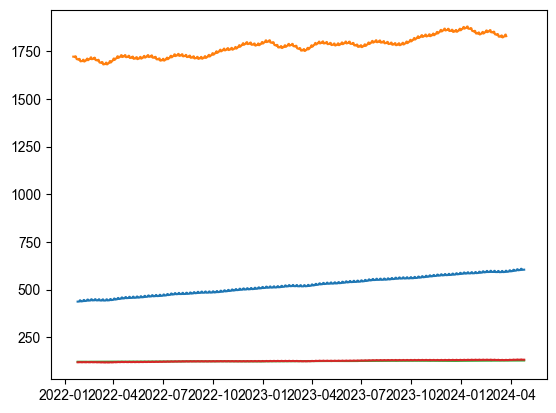

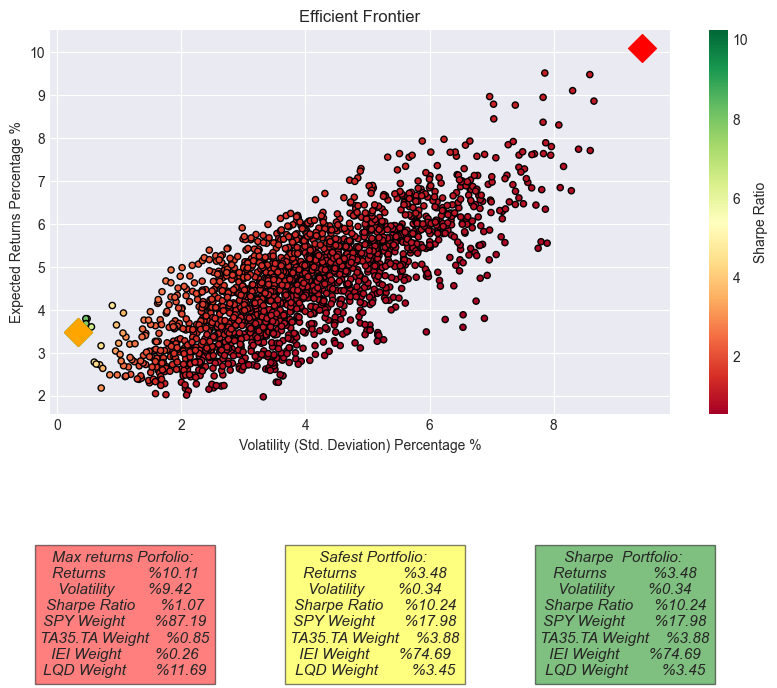

In [10]:
selected = ["SPY", "TA35.TA", "IEI", "LQD"]
record_percentage_to_predict = 0.2
print("test")
prophet("2009-01-01", "2025-05-07", 2000, selected, record_percentage_to_predict)

#Markovich Model with Random Forest

##Functions Explanation:
###price_forecast_rf():
This function uses a Random Forest Regressor to predict future stock prices based on historical data. It replaces linear regression with a non-linear, ensemble learning method that improves prediction robustness and handles noisy financial data better.

- **Data Collection:**
Downloads historical stock data using Yahoo Finance between the specified start and end dates.

- **Feature Engineering:**
Calculates:

    - HL_PCT: The high-low percentage (daily volatility indicator).

    - PCT_change: The percent change between open and close prices.

    - Selects four features: Close, HL_PCT, PCT_change, and Volume.

- **Label Creation for Forecasting:**
Sets the prediction target (label) to be the Close price shifted into the future.
The forecast_out variable defines how many future days to predict, based on the record_percentage_to_predict.

- **Data Preprocessing:**
Scales the features using preprocessing.scale() to standardize inputs.
Separates the data into:

  - X_lately: Unseen data to be predicted.

  - X, y: Features and labels used for training/testing.

  - Splits the data into training and test sets.

- **Model Training and Prediction:**
Uses RandomForestRegressor (an ensemble of decision trees) for training.
Trains the model on the historical dataset and evaluates prediction accuracy with .score().

- **Forecasting:**
Predicts future stock prices using the trained model on X_lately.
Appends the forecasted values to the DataFrame, aligned to future dates for later analysis.

- **Return Value:**
Returns the predicted future values (Forecast column), which are used in portfolio simulations like markovich().

###random_forest():
This function runs the Markowitz portfolio optimization model using stock price forecasts generated by a Random Forest Regressor. It takes a list of stock tickers, a date range, a test set size, and the number of portfolio simulations to perform.

- **Forecasting Prices with Random Forest:**
For each selected stock, the price_forecast_rf() function is used to generate future stock price predictions using a Random Forest model.
Each forecasted price series is collected into a dictionary and converted to a DataFrame.

- **Return & Risk Calculations:**
Computes daily returns from forecasted prices.
Calculates annual returns and the annualized covariance matrix, which reflects how asset returns co-vary and impact portfolio risk.

- **Portfolio Simulation:**
Randomly generates many different portfolios by assigning random weights to each stock (summing to 1).
**For each simulated portfolio:**

   - Computes expected return, volatility (risk), and Sharpe ratio (risk-adjusted return).
   
   - Stores these values for later analysis.

- **Portfolio Analysis:**
Assembles all simulated portfolios into a DataFrame with columns for returns, volatility, Sharpe ratio, and each stock’s weight.

- Identifies three key portfolios:

    - Maximum return portfolio

    - Minimum volatility (safest) portfolio

    - Maximum Sharpe ratio portfolio

- **Visualization:**
Plots all portfolios on an Efficient Frontier graph, with Sharpe ratios color-coded.
Highlights the three optimal portfolios with colored markers.
Prints a styled summary of each optimal portfolio below the graph.

In [44]:
def price_forecast_rf(stock, start_date, end_date, record_percentage_to_predict):
    """

    """
    df = yf.download(stock, start=start_date, end=end_date)

    df['HL_PCT'] = (df['High'] - df['Low']) / df['Low'] * 100.0
    df['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

    df = df[['Close', 'HL_PCT', 'PCT_change', 'Volume']]

    forecast_col = 'Close'
    # forecast_col = 'Adj. Close'
    df.fillna(value=-99999, inplace=True)
    forecast_out = int(math.ceil(record_percentage_to_predict * len(df)))
    df['label'] = df[forecast_col].shift(-forecast_out)
    print(df.head())


    X = np.array(df.drop(['label'], axis=1))
    X = preprocessing.scale(X)
    X_lately = X[-forecast_out:]
    X = X[:-forecast_out]
    df.dropna(inplace=True)
    df['Close'].plot()
    y = np.array(df['label'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=record_percentage_to_predict)
    # clf =  svm.SVR() # #LinearRegression()
    clf = RandomForestRegressor(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print(confidence)
    forecast_set = clf.predict(X_lately)
    df['Forecast'] = np.nan

    last_date = df.iloc[-1].name
    last_unix = last_date.timestamp()
    one_day = 86400
    next_unix = last_unix + one_day

    for i in forecast_set:
        next_date = datetime.datetime.fromtimestamp(next_unix)
        next_unix += 86400
        df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]

    col = df['Forecast']
    col = col.dropna()
    return col

In [46]:
def random_forest(start_date, end_date, Num_porSimulation, selected, record_percentage_to_predict):

    #yf.pdr_override()
    frame = {}
    for stock in selected:
        # call price_forecast on each stock and get prediction for it's prices
        price = price_forecast_rf(stock, start_date, end_date, record_percentage_to_predict)
        frame[stock] = price
    #frame.to_csv('1.csv')
    table = pd.DataFrame(frame)
    plt.plot(pd.DataFrame(frame))
    pd.DataFrame(frame).to_csv('Out.csv')

    returns_daily = table.pct_change()
    returns_daily.to_csv('Out1.csv')
    returns_annual = ((1 + returns_daily.mean()) ** 254) - 1
    returns_annual.to_csv('Out2.csv')

    # get daily and covariance of returns of the stock
    cov_daily = returns_daily.cov()
    cov_annual = cov_daily * 250

    # empty lists to store returns, volatility and weights of imiginary portfolios
    port_returns = []
    port_volatility = []
    sharpe_ratio = []
    stock_weights = []

    # set the number of combinations for imaginary portfolios
    num_assets = len(selected)
    num_portfolios = Num_porSimulation  # Change porfolio numbers here

    # set random seed for reproduction's sake
    np.random.seed(101)

    # populate the empty lists with each portfolios returns,risk and weights
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, returns_annual)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        sharpe = returns / volatility
        sharpe_ratio.append(sharpe)
        port_returns.append(returns * 100)
        port_volatility.append(volatility * 100)
        stock_weights.append(weights)

    # a dictionary for Returns and Risk values of each portfolio
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility,
                 'Sharpe Ratio': sharpe_ratio}

    # extend original dictionary to accomodate each ticker and weight in the portfolio
    for counter, symbol in enumerate(selected):
        portfolio[symbol + ' Weight'] = [Weight[counter] for Weight in stock_weights]

    # make a nice dataframe of the extended dictionary
    df = pd.DataFrame(portfolio)

    # get better labels for desired arrangement of columns
    column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock + ' Weight' for stock in selected]

    # reorder dataframe columns
    df = df[column_order]

    # plot frontier, max sharpe & min Volatility values with a scatterplot
    # find min Volatility & max sharpe values in the dataframe (df)
    min_volatility = df['Volatility'].min()
    # min_volatility1 = df['Volatility'].min()+1
    max_sharpe = df['Sharpe Ratio'].max()
    max_return = df['Returns'].max()
    max_vol = df['Volatility'].max()
    # use the min, max values to locate and create the two special portfolios
    sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
    min_variance_port = df.loc[df['Volatility'] == min_volatility]
    max_returns = df.loc[df['Returns'] == max_return]
    max_vols = df.loc[df['Volatility'] == max_vol]

    # plot frontier, max sharpe & min Volatility values with a scatterplot
    plt.style.use('seaborn-v0_8-dark')
    df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                    cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
    plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='green', marker='D', s=200)
    plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='orange', marker='D', s=200)
    plt.scatter(x=max_vols['Volatility'], y=max_returns['Returns'], c='red', marker='D', s=200)
    plt.style.use('seaborn-v0_8-dark')

    plt.xlabel('Volatility (Std. Deviation) Percentage %')
    plt.ylabel('Expected Returns Percentage %')
    plt.title('Efficient Frontier')
    plt.subplots_adjust(bottom=0.4)
    # ------------------ Pritning 3 optimal Protfolios -----------------------
    # Setting max_X, max_Y to act as relative border for window size

    red_num = df.index[df["Returns"] == max_return]
    yellow_num = df.index[df['Volatility'] == min_volatility]
    green_num = df.index[df['Sharpe Ratio'] == max_sharpe]
    multseries = pd.Series([1, 1, 1] + [100 for stock in selected],
                           index=['Returns', 'Volatility', 'Sharpe Ratio'] + [stock + ' Weight' for stock in selected])
    with pd.option_context('display.float_format', '%{:,.2f}'.format):
        plt.figtext(0.2, 0.15, "Max returns Porfolio: \n" + df.loc[red_num[0]].multiply(multseries).to_string(),
                    bbox=dict(facecolor='red', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center',
                    wrap=True)
        plt.figtext(0.45, 0.15, "Safest Portfolio: \n" + df.loc[yellow_num[0]].multiply(multseries).to_string(),
                    bbox=dict(facecolor='yellow', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center',
                    wrap=True)
        plt.figtext(0.7, 0.15, "Sharpe  Portfolio: \n" + df.loc[green_num[0]].multiply(multseries).to_string(),
                    bbox=dict(facecolor='green', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center',
                    wrap=True)
    plt.show()

[*********************100%***********************]  1 of 1 completed

test
Price           Close    HL_PCT PCT_change     Volume       label
Ticker            SPY                             SPY            
Date                                                             
2009-01-02  68.760574  3.995553   2.786374  227566300  107.537804
2009-01-05  68.679214  1.926221   0.237505  240349700  108.408226
2009-01-06  69.137825  1.909794  -0.181544  328260900  109.824722
2009-01-07  67.066719  2.283820  -1.445654  280899200  108.519043
2009-01-08  67.340393  1.583582   0.976040  263834400  108.447830



<ipython-input-44-7d419cf3da69>:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


0.9883963484373703


[*********************100%***********************]  1 of 1 completed
<ipython-input-44-7d419cf3da69>:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))


Price            Close    HL_PCT PCT_change  Volume        label
Ticker         TA35.TA                      TA35.TA             
Date                                                            
2009-01-01  667.390015  2.128178   1.379292       0  1129.430054
2009-01-04  674.239990  1.713038  -0.580967       0  1135.660034
2009-01-05  679.950012  1.438919   0.793068       0  1146.780029
2009-01-06  702.900024  2.960334   2.909095       0  1141.569946
2009-01-07  694.580017  2.172404  -0.465729       0  1144.849976
0.6966185879060343


[*********************100%***********************]  1 of 1 completed
<ipython-input-44-7d419cf3da69>:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))


Price           Close    HL_PCT PCT_change  Volume      label
Ticker            IEI                          IEI           
Date                                                         
2009-01-02  86.699364  1.115960  -0.940388   78500  99.045502
2009-01-05  86.759789  0.435920  -0.225775  487100  98.948067
2009-01-06  86.842880  0.708356   0.410338  363700  98.858841
2009-01-07  86.978722  0.400941   0.243668   67400  99.053574
2009-01-08  87.144966  0.399999   0.130142   34800  99.118477
0.8664782057610434


[*********************100%***********************]  1 of 1 completed
<ipython-input-44-7d419cf3da69>:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))


Price           Close    HL_PCT PCT_change   Volume      label
Ticker            LQD                           LQD           
Date                                                          
2009-01-02  54.546364  1.164301  -0.876847  1095800  73.556145
2009-01-05  54.920441  1.638361   1.148279  2938400  73.479713
2009-01-06  55.012592  1.161873   0.217285  2036600  73.511574
2009-01-07  54.551754  1.037407  -0.612401  1675100  73.861801
2009-01-08  54.942089  0.795619   0.735584  1445200  73.861801
0.9263395409848532


<ipython-input-46-df4a034f8d63>:12: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(pd.DataFrame(frame))
<ipython-input-46-df4a034f8d63>:15: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_daily = table.pct_change()


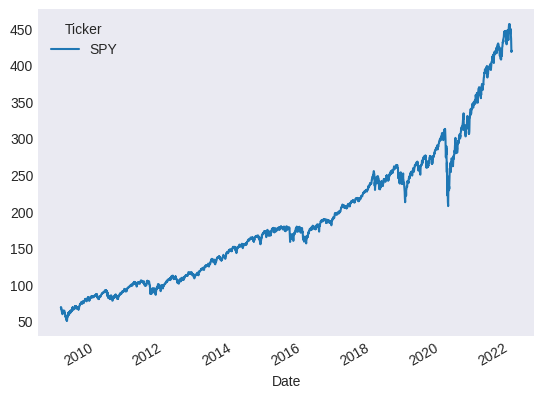

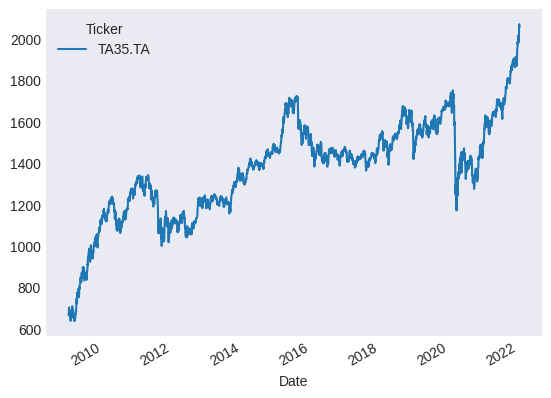

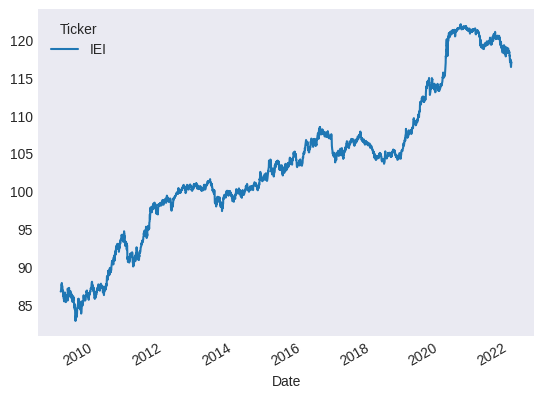

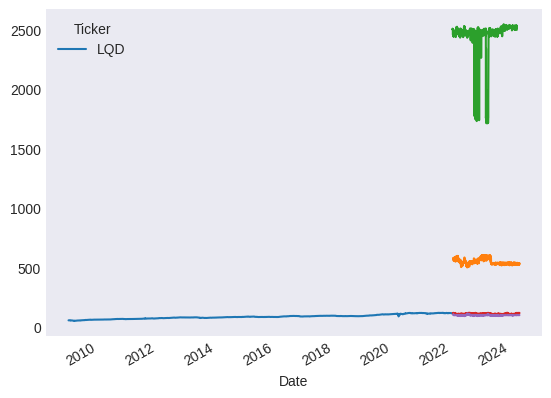

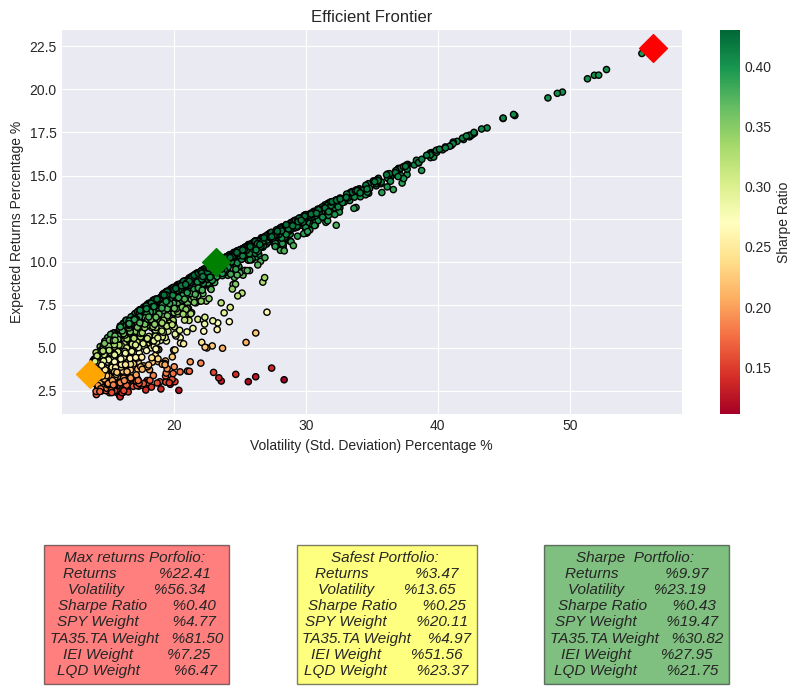

In [47]:
selected = ["SPY", "TA35.TA", "IEI", "LQD"]
record_percentage_to_predict = 0.2
print("test")
random_forest("2009-01-01", "2025-05-07", 2000, selected, record_percentage_to_predict)